## Importing necessary libraries

In [1]:
import copy
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## User-defined Functions

In [2]:
def initialize_parameters(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)  # no. of layers + 1 (1 for input layer)
    # Loop from l = 1 to L-1
    for l in range(1, L):
        parameters[f"W_{l}"] = np.random.randn(
            layer_dims[l], layer_dims[l - 1]
        ) / np.sqrt(
            layer_dims[l - 1]
        )  # Xavier Initialization
        parameters[f"b_{l}"] = np.zeros((layer_dims[l], 1))
    return parameters


def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))


def sigmoid_derivative(Z):
    sig_Z = sigmoid(Z)
    return sig_Z * (1 - sig_Z)


def sigmoid_backward(dA, Z):
    dZ = dA * sigmoid_derivative(Z)
    return dZ


def relu(Z):
    return np.maximum(0, Z)


def relu_derivative(z):
    return np.where(z <= 0, 0, 1)


def relu_backward(dA, Z):
    dZ = dA * relu_derivative(Z)
    return dZ


def linear_forward(A_prev, W, b, activation):
    Z = np.dot(W, A_prev) + b
    if activation == "sigmoid":
        A = sigmoid(Z)
    elif activation == "relu":
        A = relu(Z)
    cache = (A_prev, Z, W, b)
    return A, cache


def forward_prop(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network
    # Loop from l = 1 to L-1 (with activation == 'relu')
    for l in range(1, L):
        A_prev = A
        A, cache = linear_forward(
            A_prev, parameters[f"W_{l}"], parameters[f"b_{l}"], activation="relu"
        )
        caches.append(cache)
    # for l = L (with activation =+ 'sigmoid')
    A_L, cache = linear_forward(
        A, parameters[f"W_{L}"], parameters[f"b_{L}"], activation="sigmoid"
    )
    caches.append(cache)
    return A_L, caches


def get_cost(A_L, Y):
    epsilon = 1e-8  # Small value to prevent log(0)
    m = Y.shape[1]
    J = -np.sum(Y * np.log(A_L + epsilon) + (1 - Y) * (np.log(1 - A_L + epsilon))) / m
    return J


def linear_backward(dA, A_prev, Z, W, b, activation):
    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, Z)
    elif activation == "relu":
        dZ = relu_backward(dA, Z)
    m = A_prev.shape[1]
    dA_prev = np.dot(W.T, dZ)
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    return dA_prev, dW, db


def backward_prop(A_L, Y, caches):
    epsilon = 1e-8  # Small value to prevent division by zero
    grads = {}
    L = len(caches)  # the number of layers
    Y = Y.reshape(A_L.shape)  # after this line, Y is the same shape as A_L
    dA_L = -np.divide(Y, A_L + epsilon) + np.divide(1 - Y, 1 - A_L + epsilon)
    # loop from l = L to 1
    for l in reversed(range(1, L + 1)):
        A_prev, Z, W, b = caches[l - 1]
        if l == L:
            dA = dA_L
            dA_prev, dW, db = linear_backward(dA, A_prev, Z, W, b, "sigmoid")
        else:
            dA = dA_prev
            dA_prev, dW, db = linear_backward(dA, A_prev, Z, W, b, "relu")
        grads[f"dW_{l}"] = dW
        grads[f"db_{l}"] = db
    return grads


def update_parameters(parameters, grads, learning_rate):
    parameters = copy.deepcopy(parameters)
    L = len(parameters) // 2  # number of layers in the neural network
    for l in range(1, L + 1):
        parameters[f"W_{l}"] -= learning_rate * grads[f"dW_{l}"]
        parameters[f"b_{l}"] -= learning_rate * grads[f"db_{l}"]
    return parameters


def model(
    X,
    Y,
    layers_dims,
    learning_rate=0.0075,
    n_iters=2500,
    print_cost=False,
    print_cost_iters=100,
):
    np.random.seed(1)
    costs = []  # keep track of cost
    parameters = initialize_parameters(layers_dims)
    for i in range(1, n_iters + 1):
        A_L, caches = forward_prop(X, parameters)
        cost = get_cost(A_L, Y)
        grads = backward_prop(A_L, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if i % 100 == 0 or i == n_iters:
            costs.append(cost)
        if print_cost and (i % print_cost_iters == 0 or i == n_iters):
            print(f"Cost after iteration {i}: {cost}")
    return parameters, costs


def predict(X, parameters):
    A_L, _ = forward_prop(X, parameters)
    return (A_L > 0.5).astype(int)


def accuracy(Y_true, Y_pred):
    return f"{np.mean(Y_pred == Y_true) * 100:.2f} %"


def plot_costs(costs):
    plt.plot(np.squeeze(costs))
    plt.ylabel("Cost")
    plt.xlabel("Iterations (per hundreds)")
    plt.title("Cost vs. Iterations")
    plt.show()


def print_mislabeled_images(classes, X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:, index].reshape(64, 64, 3), interpolation="nearest")
        plt.axis("off")
        plt.title(
            f"Prediction: {classes[int(p[0,index])].decode('utf-8')}\n Class: {classes[y[0,index]].decode('utf-8')}",
            fontsize=5,
        )


def preprocess_image(image_path, image_size):
    img = Image.open(image_path)
    img = img.resize(image_size)
    img_array = np.array(img)
    img_flattened = img_array.reshape((1, -1)).T / 255.0
    return img_flattened


def show_image(image_path):
    img = Image.open(image_path)
    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


def classify_image(image_path, model_parameters, image_size=(64, 64)):
    show_image(image_path)
    img = preprocess_image(image_path, image_size)
    prediction = predict(img, model_parameters)
    if prediction == 1:
        return "Cat"
    else:
        return "Not Cat"

## Loading data

In [3]:
with h5py.File("datasets/train_catvnoncat.h5", "r") as train_set:
    train_set_x_orig = np.array(train_set["train_set_x"][:])
    train_set_y_orig = np.array(train_set["train_set_y"][:])
    classes = np.array(train_set["list_classes"][:])
with h5py.File("datasets/test_catvnoncat.h5", "r") as test_set:
    test_set_x_orig = np.array(test_set["test_set_x"][:])
    test_set_y_orig = np.array(test_set["test_set_y"][:])

## Displaying an image from the training set

'cat'

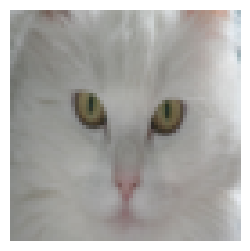

In [4]:
plt.figure(figsize=(3, 3))
plt.imshow(train_set_x_orig[50])
plt.axis("off")
# Decoding and displaying the class label of the image
classes[train_set_y_orig[50]].decode("utf-8")

In [5]:
# Printing the shapes of the datasets
print(f"train_set_x_orig: {train_set_x_orig.shape}")
print(f"train_set_y_orig: {train_set_y_orig.shape}")
print(f"test_set_x_orig: {test_set_x_orig.shape}")
print(f"test_set_y_orig: {test_set_y_orig.shape}")

# Getting the number of pixels in an image
num_px = train_set_x_orig.shape[1]
num_px

train_set_x_orig: (209, 64, 64, 3)
train_set_y_orig: (209,)
test_set_x_orig: (50, 64, 64, 3)
test_set_y_orig: (50,)


64

In [6]:
# Reshaping and normalizing the data
train_set_y = train_set_y_orig.reshape((1, -1))
test_set_y = test_set_y_orig.reshape((1, -1))

train_set_x = train_set_x_orig.reshape((train_set_x_orig.shape[0], -1)).T / 255
test_set_x = test_set_x_orig.reshape((test_set_x_orig.shape[0], -1)).T / 255

print(f"train_set_x: {train_set_x.shape}")
print(f"train_set_y: {train_set_y.shape}")
print(f"test_set_x: {test_set_x.shape}")
print(f"test_set_y: {test_set_y.shape}")

train_set_x: (12288, 209)
train_set_y: (1, 209)
test_set_x: (12288, 50)
test_set_y: (1, 50)


Cost after iteration 200: 5.171898543657102
Cost after iteration 400: 0.7051251144161244
Cost after iteration 600: 1.1932151883012203
Cost after iteration 800: 1.2997634531496411
Cost after iteration 1000: 0.03200090991198523
Cost after iteration 1200: 0.018966187516675316
Cost after iteration 1400: 0.014714311659253581
Cost after iteration 1500: 0.013398744953813171


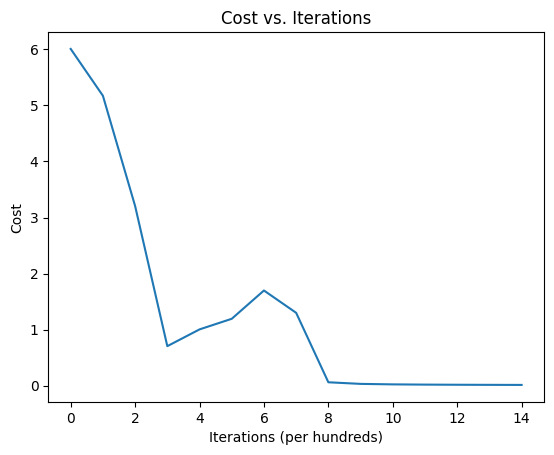

Train Accuracy:  100.00 %
Test Accuracy:  68.00 %


In [7]:
# Simple Logistic Regression
parameters, costs = model(
    train_set_x,
    train_set_y,
    layers_dims=[train_set_x.shape[0], 1],
    n_iters=1500,
    learning_rate=0.04,
    print_cost=True,
    print_cost_iters=200,
)
plot_costs(costs)

# Evaluating the model on training set
y_pred_train = predict(train_set_x, parameters)
print("Train Accuracy: ", accuracy(train_set_y, y_pred_train))

# Evaluating the model on test set
y_pred_test = predict(test_set_x, parameters)
print("Test Accuracy: ", accuracy(test_set_y, y_pred_test))

Cost after iteration 100: 0.6723877595536287
Cost after iteration 200: 0.6457504413487601
Cost after iteration 300: 0.6278240802987166
Cost after iteration 400: 0.5973174554389298
Cost after iteration 500: 0.5215481502009076
Cost after iteration 600: 0.48312829039233096
Cost after iteration 700: 0.4300969901286846
Cost after iteration 800: 0.36453312700016954
Cost after iteration 900: 0.3431782126044826
Cost after iteration 1000: 0.29340973164112183
Cost after iteration 1100: 0.25502641364355927
Cost after iteration 1200: 0.2280438943394461
Cost after iteration 1300: 0.19705590009223783
Cost after iteration 1400: 0.18372325331699843
Cost after iteration 1500: 0.16099781132838895


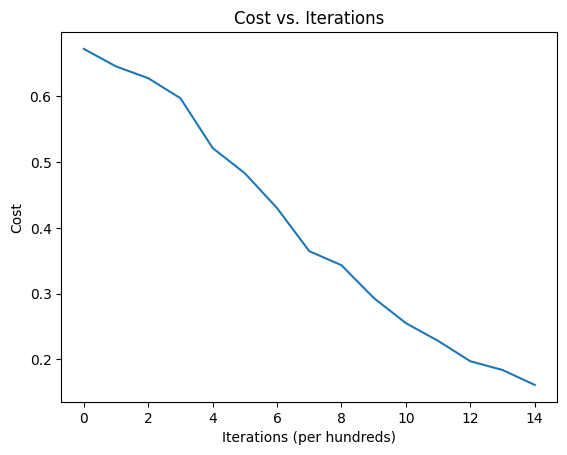

Train Accuracy:  98.09 %
Test Accuracy:  82.00 %


In [8]:
# Deep Neural Network
parameters, costs = model(
    train_set_x,
    train_set_y,
    layers_dims=[train_set_x.shape[0], 20, 7, 5, 1],
    n_iters=1500,
    print_cost=True,
)
plot_costs(costs)

# Evaluating the DNN model on training set
y_pred_train = predict(train_set_x, parameters)
print("Train Accuracy: ", accuracy(train_set_y, y_pred_train))

# Evaluating the DNN model on test set
y_pred_test = predict(test_set_x, parameters)
print("Test Accuracy: ", accuracy(test_set_y, y_pred_test))

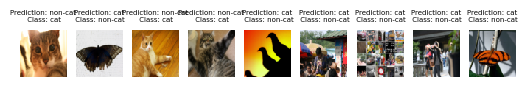

In [9]:
print_mislabeled_images(classes, test_set_x, test_set_y, y_pred_test)

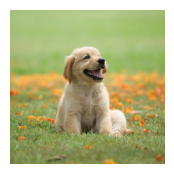

Prediction:  Not Cat


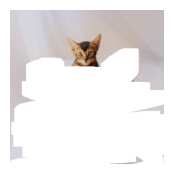

Prediction:  Cat


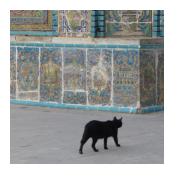

Prediction:  Cat


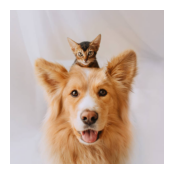

Prediction:  Cat


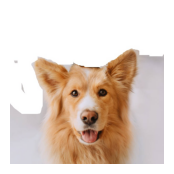

Prediction:  Not Cat


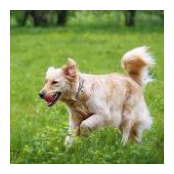

Prediction:  Not Cat


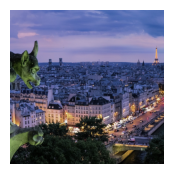

Prediction:  Not Cat


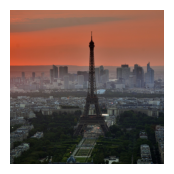

Prediction:  Not Cat


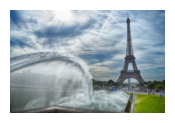

Prediction:  Not Cat


In [10]:
# Prediction on Real World Data
folder_path = "images"
image_files = os.listdir(folder_path)
for image_file in image_files:
    if not image_file.startswith("."):
        image_path = os.path.join(folder_path, image_file)
        prediction = classify_image(image_path, parameters)
        print("Prediction: ", prediction)

## Authors

Alok Ranjan

[GitHub Profile](https://www.linkedin.com/in/alokranjan-in/)

 [LinkedIn Profile](https://github.com/AlokRanjanIN)